In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
#lists of stocks by sector
banking = ['BBD','WFC','JPM','C','LYG','PYPL','ITUB','BBVA','V','AIG','HSBC','AXP']
health = ['PFE','GILD','JNJ','MRK','ABT','TMO','BMY','AMGN','AZN','GSK']
consume = ['KO','ABEV','MCD','ARCO','WMT','PG','NKE','PEP','COST','MO','TGT']
industry = ['MMM','GE','CAT','SIEGY','HON']
commodities = ['GOLD','HMY','AUY','VALE','TX','TEN','X','AGRO','PBR','OGZPY','XOM','TOT']
internet = ['AMZN','BABA','MELI','EBAY','NFLX','FB','TWTR','DIS','GOOGL']
tech = ['AAPL','MSFT','INTC','QCOM','GLOB','IBM','ADBE','NVDA','CSCO','HPQ']
air = ['DESP','ERJ','BA','RTX','LMT']

total = banking + health + consume + industry + commodities + internet + tech + air


In [3]:
df = yahoo.download(banking,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df = df.fillna(method='ffill')
start, end = df.iloc[0,:], df.iloc[-1,:]
renta = (end / start)
renta = renta.sort_values(axis=0,ascending=False)
renta

[*********************100%***********************]  12 of 12 completed


PYPL    1.826576
V       1.121058
JPM     0.972642
C       0.858719
AXP     0.819956
BBVA    0.631915
LYG     0.627957
HSBC    0.622520
AIG     0.577281
WFC     0.574983
ITUB    0.519451
BBD     0.516082
dtype: float64

In [4]:
df

,AIG,AXP,BBD,BBVA,C,HSBC,ITUB,JPM,LYG,PYPL,V,WFC
Datetime,,,,,,,,,,,,
2019-08-15 09:30:00-04:00,53.700001,122.470001,7.518182,4.700,61.650002,35.790001,8.740,105.269997,2.325,104.830002,175.369995,44.009998
2019-08-15 10:30:00-04:00,53.630001,122.360001,7.509091,4.695,61.465000,35.730000,8.785,105.190002,2.330,104.959999,175.690002,43.820000
2019-08-15 11:30:00-04:00,53.840000,122.400002,7.545455,4.700,61.400002,35.779999,8.810,105.379997,2.330,105.129997,176.270004,43.847500
2019-08-15 12:30:00-04:00,53.845001,122.559998,7.527272,4.690,61.325001,35.814999,8.780,105.199997,2.330,105.099998,176.079605,43.849998
2019-08-15 13:30:00-04:00,53.730000,122.339996,7.427272,4.670,61.080002,35.771500,8.690,104.827499,2.315,104.985001,175.919998,43.467701
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-14 11:30:00-04:00,31.059999,100.739998,3.930000,2.980,53.105000,22.285000,4.605,102.779999,1.470,191.410095,196.960007,25.325001
2020-08-14 12:30:00-04:00,31.030001,100.690002,3.910000,2.990,52.961498,22.245001,4.585,102.751198,1.470,191.639999,196.878693,25.311100
2020-08-14 13:30:00-04:00,31.219999,100.739998,3.910000,2.985,53.130001,22.209999,4.585,102.830002,1.470,191.660004,196.960007,25.376699


In [5]:
noa = len(df.columns) #number of assets
weights = np.random.random(noa)
weights /= np.sum(weights)
observations = 20
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

In [6]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-0.3,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [7]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,3) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

V       0.300
PYPL    0.300
JPM     0.300
HSBC    0.300
ITUB    0.219
WFC     0.111
BBVA    0.055
AXP     0.029
LYG     0.004
AIG    -0.051
BBD    -0.267
C      -0.300
Name: weigths, dtype: float64

In [8]:
portfolio = (df * minimal_VaR.weigths).T.sum()

retorno = portfolio.pct_change().cumsum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


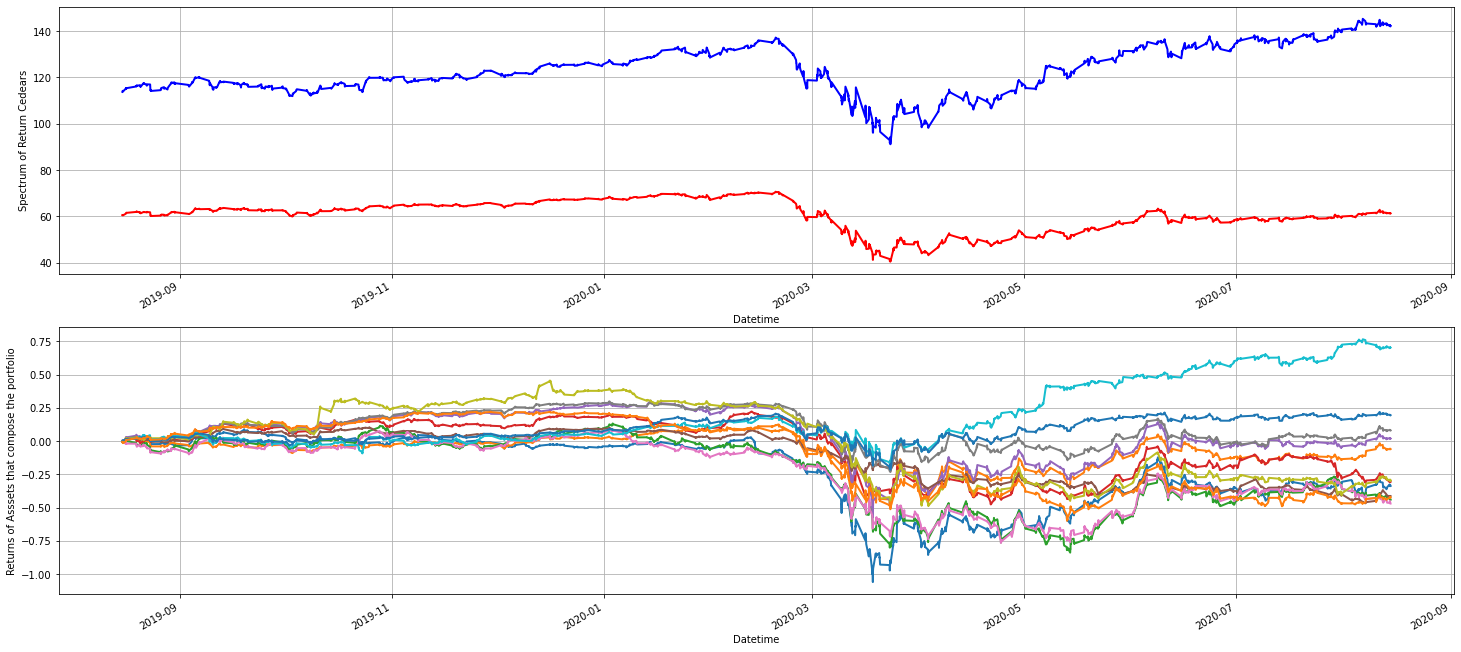

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfolio.plot(ax=ax1, color='b', lw=2.)
benchmark.plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfolio, benchmark

(Datetime
 2019-08-15 09:30:00-04:00    113.755543
 2019-08-15 10:30:00-04:00    113.895364
 2019-08-15 11:30:00-04:00    114.201405
 2019-08-15 12:30:00-04:00    114.116682
 2019-08-15 13:30:00-04:00    113.945882
                                 ...    
 2020-08-14 11:30:00-04:00    142.376470
 2020-08-14 12:30:00-04:00    142.443505
 2020-08-14 13:30:00-04:00    142.435257
 2020-08-14 14:30:00-04:00    141.993874
 2020-08-14 15:30:00-04:00    142.210526
 Length: 1765, dtype: float64,
 Datetime
 2019-08-15 09:30:00-04:00    60.531098
 2019-08-15 10:30:00-04:00    60.513675
 2019-08-15 11:30:00-04:00    60.619413
 2019-08-15 12:30:00-04:00    60.591822
 2019-08-15 13:30:00-04:00    60.435331
                                ...    
 2020-08-14 11:30:00-04:00    61.387508
 2020-08-14 12:30:00-04:00    61.371874
 2020-08-14 13:30:00-04:00    61.423059
 2020-08-14 14:30:00-04:00    61.193176
 2020-08-14 15:30:00-04:00    61.272083
 Length: 1765, dtype: float64)

In [11]:
minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

V       0.30
PYPL    0.30
JPM     0.30
HSBC    0.30
ITUB    0.22
WFC     0.11
BBVA    0.05
AXP     0.03
LYG     0.00
AIG    -0.05
BBD    -0.27
C      -0.30
Name: weigths, dtype: float64

In [12]:
portfolio = (df * minimal_VaR.weigths).T.sum()
portfolio

Datetime
2019-08-15 09:30:00-04:00    113.841088
2019-08-15 10:30:00-04:00    113.980996
2019-08-15 11:30:00-04:00    114.287151
2019-08-15 12:30:00-04:00    114.202666
2019-08-15 13:30:00-04:00    114.032282
                                ...    
2020-08-14 11:30:00-04:00    142.454980
2020-08-14 12:30:00-04:00    142.521939
2020-08-14 13:30:00-04:00    142.513890
2020-08-14 14:30:00-04:00    142.072265
2020-08-14 15:30:00-04:00    142.288851
Length: 1765, dtype: float64

In [13]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [14]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
AIG,0.083333,0.677237,0.015435,0.031360,0.309225
AXP,0.083333,0.732119,0.012501,0.027457,0.309225
BBD,0.083333,0.680203,0.015786,0.032213,0.309225
BBVA,0.083333,0.693210,0.013036,0.027110,0.309225
C,0.083333,0.762312,0.013900,0.031788,0.309225
HSBC,0.083333,0.655631,0.008278,0.016283,0.309225
ITUB,0.083333,0.656500,0.014488,0.028535,0.309225
JPM,0.083333,0.748302,0.011024,0.024748,0.309225
LYG,0.083333,0.649906,0.013792,0.026890,0.309225
PYPL,0.083333,0.541750,0.010743,0.017460,0.309225


In [15]:
poe, fullstress

(AIG    -10.855416
 AXP    -10.026463
 BBD    -11.813585
 BBVA   -15.845672
 C      -10.648115
 HSBC   -10.393292
 ITUB   -11.358008
 JPM    -13.085606
 LYG    -12.707589
 PYPL   -11.034603
 V      -10.806500
 WFC     -9.722325
 dtype: float64,
 -3.5784068088496825)

In [16]:
portfolio = data.T.mean()
portfolio

Datetime
2019-08-15 09:30:00-04:00    60.531098
2019-08-15 10:30:00-04:00    60.513675
2019-08-15 11:30:00-04:00    60.619413
2019-08-15 12:30:00-04:00    60.591822
2019-08-15 13:30:00-04:00    60.435331
                               ...    
2020-08-14 11:30:00-04:00    61.387508
2020-08-14 12:30:00-04:00    61.371874
2020-08-14 13:30:00-04:00    61.423059
2020-08-14 14:30:00-04:00    61.193176
2020-08-14 15:30:00-04:00    61.272083
Length: 1765, dtype: float64

In [17]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [18]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
AIG,0.001082,-0.022258,0.048591,0.032907,0.267433,0.022286,0.231951,0.096081
AXP,0.001011,-0.022258,0.045432,0.033262,0.292219,0.024352,0.231951,0.104986
BBD,0.001124,-0.022258,0.050486,0.034341,0.280302,0.023359,0.231951,0.100704
BBVA,0.000949,-0.022258,0.042638,0.029557,0.245870,0.020489,0.231951,0.088334
C,0.001223,-0.022258,0.054950,0.041889,0.383187,0.031932,0.231951,0.137668
HSBC,0.000530,-0.022258,0.023820,0.015617,0.122866,0.010239,0.231951,0.044142
ITUB,0.000961,-0.022258,0.043196,0.028358,0.223405,0.018617,0.231951,0.080263
JPM,0.000930,-0.022258,0.041763,0.031251,0.280626,0.023386,0.231951,0.100821
LYG,0.000883,-0.022258,0.039671,0.025782,0.201072,0.016756,0.231951,0.072239
PYPL,0.000463,-0.022258,0.020811,0.011274,0.073295,0.006108,0.231951,0.026333


In [19]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weigths
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
AIG,0.083333,0.096081,-0.05,0.008007,-0.004804,-0.012811,-1.60,0.0300,7.0716,0.004242
AXP,0.083333,0.104986,0.03,0.008749,0.003150,-0.005599,-0.64,0.0108,7.0716,0.001527
BBD,0.083333,0.100704,-0.27,0.008392,-0.027190,-0.035582,-4.24,0.8748,7.0716,0.123706
BBVA,0.083333,0.088334,0.05,0.007361,0.004417,-0.002944,-0.40,0.0300,7.0716,0.004242
C,0.083333,0.137668,-0.30,0.011472,-0.041300,-0.052773,-4.60,1.0800,7.0716,0.152724
HSBC,0.083333,0.044142,0.30,0.003679,0.013243,0.009564,2.60,1.0800,7.0716,0.152724
ITUB,0.083333,0.080263,0.22,0.006689,0.017658,0.010969,1.64,0.5808,7.0716,0.082131
JPM,0.083333,0.100821,0.30,0.008402,0.030246,0.021845,2.60,1.0800,7.0716,0.152724
LYG,0.083333,0.072239,0.00,0.006020,0.000000,-0.006020,-1.00,0.0000,7.0716,0.000000
PYPL,0.083333,0.026333,0.30,0.002194,0.007900,0.005705,2.60,1.0800,7.0716,0.152724


In [20]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

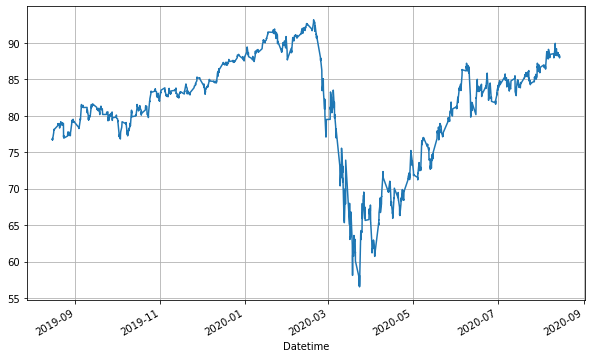

In [21]:
p = propuesta.plot(figsize=(10,6))
p.grid()

In [22]:
propuesta

Datetime
2019-08-15 09:30:00-04:00    76.738054
2019-08-15 10:30:00-04:00    76.755329
2019-08-15 11:30:00-04:00    76.904687
2019-08-15 12:30:00-04:00    76.832989
2019-08-15 13:30:00-04:00    76.661580
                               ...    
2020-08-14 11:30:00-04:00    88.206663
2020-08-14 12:30:00-04:00    88.192369
2020-08-14 13:30:00-04:00    88.242475
2020-08-14 14:30:00-04:00    87.932242
2020-08-14 15:30:00-04:00    88.064113
Length: 1765, dtype: float64

In [23]:
ponderaciones = cartera.MinCVaR.sort_values(axis=0,ascending=False)
ponderaciones.head(10)

V       0.152724
PYPL    0.152724
JPM     0.152724
HSBC    0.152724
C       0.152724
BBD     0.123706
ITUB    0.082131
WFC     0.020533
BBVA    0.004242
AIG     0.004242
Name: MinCVaR, dtype: float64